In [1]:
# Window
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.output_result { width:90% !important; }</style>"))

# Spectral assisted column generation model for Graph Partitioning in Connected Components

## Problem statement

Let 
* $G = (V,E)$ be an undirected graph, with $V = \{1,\ldots, n\}$ being its node set, and $E \subset \{ \{i,j\}:\, i,j\in V, i \neq j \}$ being its edge set. 
* $ d: E \to \mathbb{R}^{+}$ be a cost function, 
* $k\geq 2$ an integer denoting the fixed number of connected components to partition $G$ into,
* $\alpha \geq 2$ an integer numbers representing the minimum cardinality of each connected component.

A $k$-partition of $V$ is a set $\{V_1,V_2,\ldots,V_k\}$ where $V_i\cap V_j=\emptyset$ for all $i\neq j$, $\bigcup_{c=1}^k V_c=V$, and $V_c \neq \emptyset$ for all $ c \in [k]$, where $[k]$ denotes the set $\{1,\ldots,k\}$. 


The partitioning problem in connected components with minimum size constraints consists of finding a  $k$-partition $\{V_1,V_2,\ldots,V_k\}$ such that each subset $V_c$ induces a connected subgraph, with $|V_c| \geq \alpha$, and the total cost of the edges with end nodes in the same subset of the partition is minimized.


Observe that each connected component of $G$ will have at most $\beta := n-(k-1)\alpha$ nodes. Moreover,  $\alpha$ has to be less than $ \left\lceil \frac{n}{k} \right\rceil$, otherwise the problem is infeasible.

The graph partitioning problem in connected components with minimum size constraints is modeled as a set partitioning problem, where each node must be assigned to exactly one connected component. Given a finite family $\mathcal{F}$ of all induced connected subgraphs of $G$ with number of nodes between $\alpha$ and $\beta$, the task consists of finding a subfamily $F\subseteq \mathcal{F}$, with cardinality $|F| = k$, of pairwise disjoint subgraphs such that $\bigcup_{f\in F} f = V$, and the total cost is minimized.

* $a_{i,f} \in \{0,1\}$ takes the value of one if the connected component $f\in F$ contains the node $i \in V$, and zero otherwise. 
* $c_f\geq 0$ be the cost of $f\in F$, which is equal to the total cost of the edges in the connected component.
* $x_f$ is a decision variable taking the value of one if the connected component $f$ belongs to a solution, and zero otherwise. 

Thus, the graph partitioning problem in connected components with minimum size constraints can be formulated as follows 

\begin{align}
\min &\sum_{f\in \mathcal{F}} c_f\, x_f
\\
\text{s.t.}\qquad & 
\\
&\sum_{f\in \mathcal{F}} a_{i,f} x_f  = 1, &&\forall i \in V,
\\
&\sum_{f\in \mathcal{F}} x_f = k.
\end{align}

As the set $\mathcal{F}$ has an exponential number of elements, the model is initialized with a small subset of connected components $\hat F \subset \mathcal{F}$, and additional components are included throughout an iterative scheme.

## Comparison

### Packages

In [1]:
from   gurobipy   import *
import pandas as pd    # https://pandas.pydata.org/
import numpy  as np    # Numpy
import igraph as ig    # iGraph
import time
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

In [2]:
#from InstancesGenerator import Graph_Instance      # Not needed
from warnings     import warn
from os           import listdir
from re           import findall

from collections  import deque, Counter
from itertools    import chain 
from numpy.random import default_rng
from matplotlib   import cm

In [3]:
from scipy.sparse        import csr_matrix, spdiags
from scipy.sparse.linalg import eigs, eigsh
from k_means_constrained import KMeansConstrained

In [4]:
# Aliases
from numpy import argsort, delete, unique, floor, ceil, argsort, around
# Formatting
np.set_printoptions(edgeitems=100, linewidth=160, formatter=dict(float=lambda x: "%.3g" % x))

### Load data

An instance is selected. For more information about the available instances, see [```Instance generator NB.ipynb```](Instance%20generator%20NB.ipynb) and the associated function [```InstancesGenerator.py```](InstancesGenerator.py).

In [5]:
name_in = 'Results/{0}.xlsx'.format('Spec_Col_Gen_δ=40')

'Results/Spec_Col_Gen_δ=40.xlsx'

In [11]:
# Two datasets are loaded, index 0 corresponds to tests with default algorithm, and index 1 corresponds to tests with CCSKL
Relaxation_Values = pd.read_excel(name_in, [0,1], index_col=0)

In [12]:
Relaxation_Values[0].head()

,0,1,2,3,4,5,6,7
0,3.054957,3.355440,3.334882,3.242189,2.335663,2.855229,3.606284,11.049296
1,2.868534,2.620900,2.553646,2.464384,2.281653,2.700670,2.839707,9.649648
2,1.952586,2.077792,1.996284,2.251437,2.190691,2.359093,2.345172,9.649648
3,1.952586,2.077792,1.996284,2.235066,2.190691,2.304997,2.318076,9.649648
4,1.836207,1.964868,1.982815,2.151462,2.038138,2.257599,2.277331,9.649648


In [25]:
Rel_Obj_A = Relaxation_Values[0].values
Rel_Obj_B = Relaxation_Values[1].values

In [118]:
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['CMR10']})
rc('text', usetex=False)

/var/folders/1g/8szp6jr52h1byl43_1lx7zlm0000gn/T/ipykernel_78614/444684956.py:2: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(1,1, figsize=(10,5))


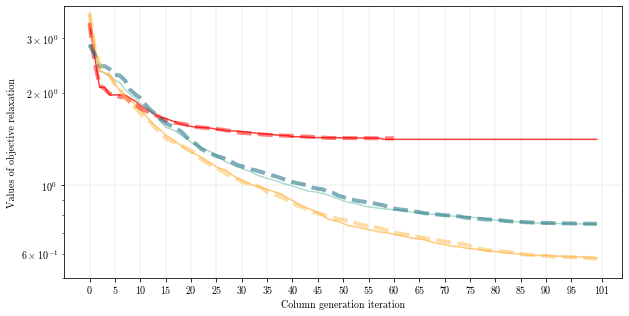

In [130]:
# Plot evolution of objective function
fig, ax = plt.subplots(1,1, figsize=(10,5))

plt.ticklabel_format(style='plain', axis='x', useOffset=False)

plt.plot(Rel_Obj_A[:,[1]],'-', alpha = 0.75, color='red')
plt.plot(Rel_Obj_A[:,[5]],'-', alpha = 0.75, color='#94d2bd')
plt.plot(Rel_Obj_A[:,[6]],'-', alpha = 0.75, color='#FEBA4F')

plt.plot(Rel_Obj_B[:,[1]],'--', alpha = 0.5, linewidth=4, color='red')
plt.plot(Rel_Obj_B[:,[5]],'--', alpha = 0.5, linewidth=4, color='#005f73')
plt.plot(Rel_Obj_B[:,[6]],'--', alpha = 0.5, linewidth=4, color='#FEBA4F')

ax.set_ylim(0.5,3.8)

# Add more ticks in y-axis
ax_base = [0, 0, 0]
ax_val  = [1, 2, 3]
ax_loc  = ax_val * 10.0**np.asarray(ax_base)
ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
           plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
           for a in zip(ax_loc, ax_base, ax_val) ]
ax.set_yticks(ax_loc, ax_lbl, fontname='CMR10')

#plt.title('Evolution of relaxed objective')
plt.xlabel('Column generation iteration', fontname='CMR10');
plt.ylabel('Values of objective relaxation', fontname='CMR10');
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1)); 
plt.xticks(np.unique(np.r_[np.arange(0,len(RelObj), 5)[:-1], [len(RelObj)]]), fontname='CMR10');




plt.yscale('log')

plt.grid('on', which = 'major', linewidth = 0.2)

fig.savefig('Col_Gen_Curves.pdf', bbox_inches='tight', pad_inches=0)

plt.show()
# A pesar de obtener soluciones similares en la relajación, se observa que las soluciones enteras pueden diferir. En particular esto ocurre para el
# caso que termina en la iteración 60

---